In [19]:
import os
import subprocess
import chess
import re

In [20]:
def combine_adjacent_digits(s):
    def replacer(match):
        # Sum the digits instead of counting them
        return str(sum(int(digit) for digit in match.group()))

    return re.sub(r'\d+', replacer, s)

def five_to_eight(fen):
    fen = fen.replace("/", "3/")
    fen = fen.split(' ')[0] + "3/8/8/8 " + fen.split(' ')[1]
    fen = combine_adjacent_digits(fen)
    return fen

5/5/5/1K2R/3k1 w - - 0 1
e2c2


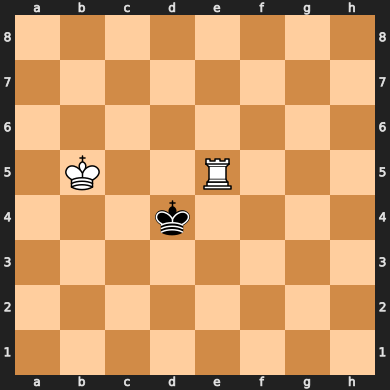

In [21]:
from engine import generate_legal_fen, best_move

fen = generate_legal_fen(5)
board = chess.Board(five_to_eight(fen))
# list(board.generate_legal_moves())
print(best_move(fen))
board

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Parameters
input_dim = 4  # Input dimension (size of one-hot token)
output_dim = 16  # Output dimension (size of output one-hot vector)
d_model = 128  # Dimension of the model
nhead = 1  # Number of heads in the multiheadattention models
dim_feedforward = 128  # Dimension of the feedforward network model
num_tokens = 25  # Number of tokens in the sequence
batch_size = 32  # Batch size for training
num_batches = 100  # Number of batches for training
learning_rate = 0.001  # Learning rate for the optimizer

# Define the transformer model
class OneLayerTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, dim_feedforward):
        super(OneLayerTransformer, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=1)
        self.fc_out = nn.Linear(d_model, output_dim)
        self.src_mask = None

    def forward(self, src):
        src = self.embedding(src)
        memory = torch.zeros(src.size(0), src.size(1), d_model).to(src.device)
        output = self.transformer_decoder(src, memory, self.src_mask)
        return self.fc_out(output)

# Generate random data
def generate_random_data(batch_size, num_tokens, input_dim, output_dim):
    inputs = torch.randint(0, input_dim, (batch_size, num_tokens))
    outputs = torch.randint(0, output_dim, (batch_size, num_tokens))
    return inputs, outputs

def train():
    # Create the model
    model = OneLayerTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for _ in range(num_batches):
        inputs, labels = generate_random_data(batch_size, num_tokens, input_dim, output_dim)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_function(output.transpose(1, 2), labels)
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()}")

    # Test the model
    test_inputs, _ = generate_random_data(1, num_tokens, input_dim, output_dim)
    test_output = model(test_inputs)
    print("Test input:", test_inputs)
    print("Test output:", test_output.argmax(dim=2))


Loss: 2.910170793533325
Loss: 2.874380588531494
Loss: 2.8255703449249268
Loss: 2.8095016479492188
Loss: 2.8060293197631836
Loss: 2.779151201248169
Loss: 2.8056869506835938
Loss: 2.7923529148101807
Loss: 2.796072483062744
Loss: 2.795565128326416
Loss: 2.798022747039795
Loss: 2.792816400527954
Loss: 2.8029541969299316
Loss: 2.786135673522949
Loss: 2.791512966156006
Loss: 2.7912375926971436
Loss: 2.785095453262329
Loss: 2.7871100902557373
Loss: 2.7918601036071777
Loss: 2.7857658863067627
Loss: 2.791928291320801
Loss: 2.7845916748046875
Loss: 2.7903618812561035
Loss: 2.781442165374756
Loss: 2.7895572185516357
Loss: 2.780660629272461
Loss: 2.7782142162323
Loss: 2.7915303707122803
Loss: 2.78133487701416
Loss: 2.7803537845611572
Loss: 2.7836883068084717
Loss: 2.785522699356079
Loss: 2.7842345237731934
Loss: 2.7851202487945557
Loss: 2.7857110500335693
Loss: 2.7803802490234375
Loss: 2.7880704402923584
Loss: 2.7738149166107178
Loss: 2.7804038524627686
Loss: 2.783764600753784
Loss: 2.780554771423

In [31]:
# Example data
zipped_data = [([1, 2, 3, 4, 5, ...], 1), ([6, 7, 8, 9, 10, ...], 2), ...]  # Replace with your data

# Unzip the input and output data
input_data, output_data = zip(*zipped_data)

# Create the custom dataset
dataset = CustomDataset(input_data, output_data)

# Create a DataLoader to handle batching
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage
for inputs, outputs in dataloader:
    # Apply your model and calculate loss here
    pass


In [24]:
inputs, labels = generate_random_data(batch_size, num_tokens, input_dim, output_dim)
inputs.shape, labels.shape

(torch.Size([32, 25, 4]), torch.Size([32, 25, 16]))

In [34]:
output_data

(1, 2)